# Extract features from textual data using BERT and Path signature

In [1]:
import pandas as pd
import torch
import pickle
import re

import nlpsig
from nlpsig.ffn import FeedforwardNeuralNetModel
from nlpsig.focal_loss import FocalLoss
from nlpsig.huggingface_loader import loadHF

/Users/rchan/opt/miniconda3/envs/py38esig/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load dataset

In this notebook, we use the `newspop` dataset from Huggingface and add timeline IDs and post IDs to each item. The `loadHF` class is to process this dataset.

In [2]:
# loadHF: load a dataset from hugging face
data_loader = loadHF(dataset_name="newspop", split_name="train")
data_loader.load_preprocessed_df(default_preprocess="newspop")
dataset_df = data_loader.dataset_df

[INFO] load dataframe, split: train...


Found cached dataset newspop (/Users/rchan/.cache/huggingface/datasets/newspop/default/0.0.0/9904d4082ffd3c0953efa538ff926c43d27da8f37c9b5d6a13f51ab96740474e)
100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 295.50it/s]


[INFO] preprocess...
[INFO] preprocessed dataframe can be accessed: .dataset_df


In [3]:
dataset_df.head()

,content,datetime,label,timeline_id,post_id
0,Obama Lays Wreath at Arlington National Cemete...,2015-01-06 00:12:00,1,11,6
1,"Tim Haywood, investment director business-unit...",2015-01-03 00:12:00,2,5,3
2,"Nouriel Roubini, NYU professor and chairman at...",2015-01-04 00:12:00,2,7,1
3,Finland's economy expanded marginally in the t...,2015-01-02 00:00:00,2,2,2
4,Tourism and public spending continued to boost...,2015-01-04 00:00:00,2,6,3


In [4]:
len(dataset_df)

93239

We use a smaller subset of the data here.

In [5]:
dataset_df = dataset_df[:2000]
dataset_df["label"].value_counts()

0    1131
2     845
1      24
Name: label, dtype: int64

## Model specifics

Nested dictionary for models specifications.

This includes models for encoding text, path signature and etc.

In [6]:
model_specifics = {
    "encoder_args": {
        "col_name_text": "content",
        "model_name": "all-MiniLM-L6-v2",
        "model_args": {
            "batch_size": 64,
            "show_progress_bar": True,
            "output_value": 'sentence_embedding', 
            "convert_to_numpy": True,
            "convert_to_tensor": False,
            "device": None,
            "normalize_embeddings": False
        }
    },
    "dim_reduction": {
        "method": 'umap', #options: ppapca, ppapcappa, umap
        "num_components": 10, # options: any int number between 1 and embedding dimensions
    },
    "embedding":{
        "global_embedding_tp": 'SBERT', #options: SBERT, BERT_cls , BERT_mean, BERT_max
        "post_embedding_tp": 'sentence', #options: sentence, reduced
        "feature_combination_method": 'attention', #options concatenation, attention 
    },
    "time_injection": {
        "history_tp": 'timestamp', #options: timestamp, None
        "post_tp": 'timestamp', #options: timestamp, timediff, None
    },
    "signature": {
        "dimensions": 3, #options: any int number larger than 1
        "method": 'log', # options: log, sig
        "interval": 1/12
    }
}

## Encode text: obtaining sentence embeddings

We can use the `TextEncoder` class within `nlpsig` to obtain sentence embeddings from a model. Here, we have defined the encoder arguments in `model_specifics`.

In [7]:
model_specifics["encoder_args"]

{'col_name_text': 'content',
 'model_name': 'all-MiniLM-L6-v2',
 'model_args': {'batch_size': 64,
  'show_progress_bar': True,
  'output_value': 'sentence_embedding',
  'convert_to_numpy': True,
  'convert_to_tensor': False,
  'device': None,
  'normalize_embeddings': False}}

We can pass these into the constructor of the class to initialise our text encoder as follows:

In [8]:
# initialise the Text Encoder 
text_encoder = nlpsig.TextEncoder(dataset_df,
                                  col_name_text = model_specifics["encoder_args"]["col_name_text"], 
                                  model_name = model_specifics["encoder_args"]["model_name"],
                                  model_args = model_specifics["encoder_args"]["model_args"])

We can see that these are stored as attributes in the object:

In [9]:
text_encoder.df

,content,datetime,label,timeline_id,post_id
0,Obama Lays Wreath at Arlington National Cemete...,2015-01-06 00:12:00,1,11,6
1,"Tim Haywood, investment director business-unit...",2015-01-03 00:12:00,2,5,3
2,"Nouriel Roubini, NYU professor and chairman at...",2015-01-04 00:12:00,2,7,1
3,Finland's economy expanded marginally in the t...,2015-01-02 00:00:00,2,2,2
4,Tourism and public spending continued to boost...,2015-01-04 00:00:00,2,6,3
...,...,...,...,...,...
1995,"Over time, resilient rural producers help form...",2015-01-01 00:12:00,2,1,0
1996,So Jealous reminds Democratic candidates in 20...,2015-01-03 00:00:00,2,4,7
1997,Driven by surging manufacturing across North A...,2015-01-01 00:12:00,2,1,9
1998,Microsoft has started to roll out the first ma...,2015-01-04 00:00:00,0,6,9


In [10]:
text_encoder.col_name_text

'content'

In [11]:
text_encoder.model_name

'all-MiniLM-L6-v2'

In [12]:
text_encoder.model_args

{'batch_size': 64,
 'show_progress_bar': True,
 'output_value': 'sentence_embedding',
 'convert_to_numpy': True,
 'convert_to_tensor': False,
 'device': None,
 'normalize_embeddings': False}

There are other attributes `embeddings_sentence` and `model` which are `None` type when the class is initialised:

In [13]:
print(text_encoder.embeddings_sentence)
print(text_encoder.model)

None
None


The class has a `.encode_sentence_transformer()` method which first loads in the model (using the `model_name` and `model_args` attributes) and then obtains an embedding for each sentence. These sentence embeddings are then stored in the `embeddings_sentence` attribute of the object.

In [14]:
text_encoder.encode_sentence_transformer()
embeddings_sentence = text_encoder.embeddings_sentence

[INFO] number of sentences to encode: 2000


Batches: 100%|█████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  4.91it/s]


### Obtaining embeddings from a pickle file

Note that we could also optionally pass in any pre-computed sentence embeddings (which are saved with a pickle file) if we wanted to. So in this directory, there is a file named `pre_comp_emb.pkl`, we can load these in by:

In [15]:
text_encoder = nlpsig.TextEncoder(df = dataset_df,
                                  pre_computed_embeddings_file = "pre_comp_emb.pkl")

In [16]:
text_encoder.embeddings_sentence

array([[ 0.04053079,  0.12677227,  0.03034634, ...,  0.01346129,
         0.00509907, -0.02261563],
       [ 0.00132176, -0.0018716 ,  0.04704979, ..., -0.12755243,
        -0.00235985, -0.01032072],
       [-0.00446173, -0.07742908, -0.02367788, ..., -0.12149315,
        -0.02713374, -0.01476178],
       ...,
       [ 0.11392148, -0.08496089,  0.04116976, ..., -0.06292846,
        -0.01069093,  0.05599773],
       [-0.00467583,  0.03044874,  0.0136638 , ...,  0.01504119,
         0.07309043,  0.05808413],
       [ 0.00844448, -0.04087541,  0.0106803 , ..., -0.02920137,
         0.03407754,  0.04248996]], dtype=float32)

As we passed in a pickle file, `model_name`, `model_args`, and `model` are given default values to highlight this:

In [17]:
print("model_name: " + text_encoder.model_name)
print("model_args: " + str(text_encoder.model_args))
print("model: " + text_encoder.model)

model_name: pre-computed
model_args: None
model: pre-computed


## Plotting the embeddings with dimensionality reduction

There is a `PlotEmbedding` class within `nlpsig` which can produce two-dimensional plots of the embeddings by first performing a dimensionality reduction. We will do this here using `UMAP`:

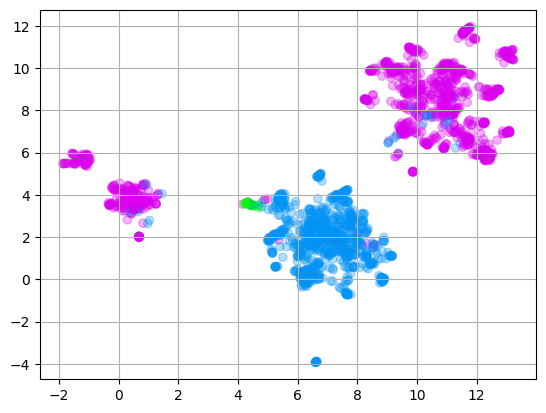

In [18]:
plt_embed = nlpsig.PlotEmbedding(x_data = embeddings_sentence,
                                 y_data = dataset_df["label"].values)

plt_embed.plt_2d(
    embed_args = {
        "method": "umap",
        "dim": 2
    }
)

## Dimensionality reduction

While the `PlotEmbedding` class allows us to visualise the embeddings, the `DimReduce` is more specific to reducing the dimensionality of the embedding space to be used later on (rather than just focus on using it for plotting). We can initialise the object by passing in what method we want to use, choosing out of:

* pca
* umap
* tsne
* ppapca
* ppapcappa

Here we specified our choices in `model_specifics` above:

In [19]:
model_specifics["dim_reduction"]

{'method': 'umap', 'num_components': 10}

The `.fit_transform()` method performs the dimensionality reduction and returns the reduced vectors (they also save them into the `embedding` attribute of the object.

In [20]:
reduction = nlpsig.DimReduce(method = model_specifics["dim_reduction"]['method'], 
                             components = model_specifics["dim_reduction"]['num_components'])
embeddings_reduced = reduction.fit_transform(embeddings_sentence)

In [21]:
print(embeddings_sentence.shape)
print(embeddings_reduced.shape)

(2000, 384)
(2000, 10)


We can again visualise these using the `PlotEmbedding` class.

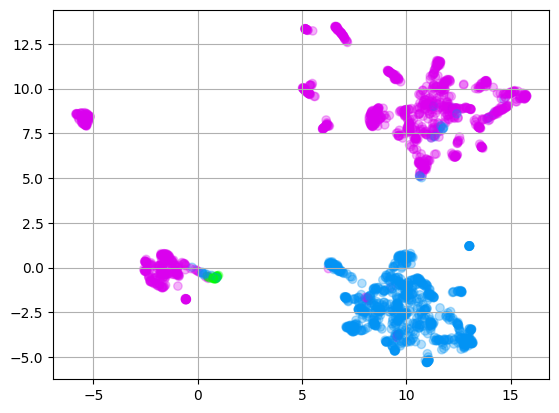

In [22]:
plt_embed = nlpsig.PlotEmbedding(x_data = embeddings_reduced,
                                 y_data = dataset_df["label"].values)

plt_embed.plt_2d(
    embed_args = {
        "method": "umap",
        "dim": 2
    }
)

## Data preparation: Time injection and Padding

Note to Talia: the `PrepareData` class now has all the `TimeInjection` and `Padding` methods and `get_modelling_df()` (so I've just combined these all together as they're all related to preparing the dataset into the correct form for later).

To use `PrepareData` class, you pass in the dataframe containing the data, the sentence embeddings, and optionally the dimension reduced sentence embeddings:

In [23]:
dataset = nlpsig.PrepareData(dataset_df, embeddings_sentence, embeddings_reduced)

The dataset is saved in `.dataset_df`, the sentence embeddings are saved in `.embeddings_sentence` and the dimension reduced embeddings are saved in `.embeddings_reduced`.

In [24]:
dataset.dataset_df

,content,datetime,label,timeline_id,post_id
0,Obama Lays Wreath at Arlington National Cemete...,2015-01-06 00:12:00,1,11,6
1,"Tim Haywood, investment director business-unit...",2015-01-03 00:12:00,2,5,3
2,"Nouriel Roubini, NYU professor and chairman at...",2015-01-04 00:12:00,2,7,1
3,Finland's economy expanded marginally in the t...,2015-01-02 00:00:00,2,2,2
4,Tourism and public spending continued to boost...,2015-01-04 00:00:00,2,6,3
...,...,...,...,...,...
1995,"Over time, resilient rural producers help form...",2015-01-01 00:12:00,2,1,0
1996,So Jealous reminds Democratic candidates in 20...,2015-01-03 00:00:00,2,4,7
1997,Driven by surging manufacturing across North A...,2015-01-01 00:12:00,2,1,9
1998,Microsoft has started to roll out the first ma...,2015-01-04 00:00:00,0,6,9


In [25]:
dataset.embeddings_sentence

array([[ 0.04053079,  0.12677227,  0.03034634, ...,  0.01346129,
         0.00509907, -0.02261563],
       [ 0.00132176, -0.0018716 ,  0.04704979, ..., -0.12755243,
        -0.00235985, -0.01032072],
       [-0.00446173, -0.07742908, -0.02367788, ..., -0.12149315,
        -0.02713374, -0.01476178],
       ...,
       [ 0.11392148, -0.08496089,  0.04116976, ..., -0.06292846,
        -0.01069093,  0.05599773],
       [-0.00467583,  0.03044874,  0.0136638 , ...,  0.01504119,
         0.07309043,  0.05808413],
       [ 0.00844448, -0.04087541,  0.0106803 , ..., -0.02920137,
         0.03407754,  0.04248996]], dtype=float32)

In [26]:
dataset.embeddings_reduced

array([[ 4.936433  ,  6.493924  , -0.11072106, ...,  7.0296464 ,
        10.750452  ,  4.7098427 ],
       [ 4.5180726 ,  6.1551723 , -1.9758633 , ...,  8.525169  ,
        12.055894  ,  4.466243  ],
       [ 4.475151  ,  5.547805  , -1.1352187 , ...,  8.3394    ,
        11.823152  ,  5.0529327 ],
       ...,
       [ 4.363275  ,  6.921214  , -1.1200932 , ...,  8.875484  ,
        11.563797  ,  5.282164  ],
       [ 4.3113284 , 10.814843  , -4.189246  , ...,  9.7759    ,
        12.214205  ,  3.7648683 ],
       [ 3.3975155 ,  5.8468423 , -1.0891767 , ...,  9.2930765 ,
        12.733386  ,  5.3261213 ]], dtype=float32)

When initialising the object, it calls `get_modelling_df()` which combines all of three objects together, where the naming convention is `d_` for dimension reduced embeddings and `e_` for the sentence embeddings.

In [27]:
dataset.df.head()

,content,datetime,label,timeline_id,post_id,d1,d2,d3,d4,d5,...,e375,e376,e377,e378,e379,e380,e381,e382,e383,e384
0,Obama Lays Wreath at Arlington National Cemete...,2015-01-06 00:12:00,1,11,6,4.936433,6.493924,-0.110721,2.827811,-1.093754,...,0.028961,-0.038166,0.046012,0.005251,0.089081,0.020392,0.056016,0.013461,0.005099,-0.022616
1,"Tim Haywood, investment director business-unit...",2015-01-03 00:12:00,2,5,3,4.518073,6.155172,-1.975863,2.794979,0.903036,...,-0.012189,-0.046185,-0.016253,-0.018461,-0.018076,-0.086854,-0.027245,-0.127552,-0.002360,-0.010321
2,"Nouriel Roubini, NYU professor and chairman at...",2015-01-04 00:12:00,2,7,1,4.475151,5.547805,-1.135219,2.148084,0.191998,...,0.060394,-0.088560,-0.029271,0.005344,-0.070950,0.051149,-0.032960,-0.121493,-0.027134,-0.014762
3,Finland's economy expanded marginally in the t...,2015-01-02 00:00:00,2,2,2,4.310365,5.788735,-0.738454,3.271197,0.868551,...,-0.029949,-0.046079,0.001978,0.036257,-0.062178,0.075887,-0.143670,-0.059523,-0.059800,0.010529
4,Tourism and public spending continued to boost...,2015-01-04 00:00:00,2,6,3,3.447971,5.788860,-0.912544,3.149791,1.278286,...,-0.006316,0.000714,-0.021139,0.090500,-0.078927,-0.000175,0.003710,-0.012330,0.004813,0.035966


We can set the time features by calling the `.set_time_feautres()` method, which adds some columns regarding time (`time_encoding`, `time_diff` and `timeline_index` (maybe this one should get renamed actually)). This also orders the dataframe using the `time_encoding` column.

In [28]:
dataset.set_time_features()
dataset.df.head()

[INFO] Adding time feature columns into dataframe in .df


,content,datetime,label,timeline_id,post_id,d1,d2,d3,d4,d5,...,e378,e379,e380,e381,e382,e383,e384,time_encoding,time_diff,timeline_index
0,Microsoft’s AR headset is being made available...,2015-01-01,0,0,2,3.175314,10.146749,-3.431540,3.931405,-0.375022,...,-0.084646,0.033096,0.020960,-0.012285,-0.004476,0.005931,0.149044,2015.0,0,0
1,By George Georgiopoulos ATHENS (Reuters) - Gre...,2015-01-01,2,0,4,4.171477,5.676482,-0.870184,2.959400,0.223968,...,0.037292,-0.128534,0.043549,-0.030769,-0.050459,-0.039596,0.024778,2015.0,0,1
2,China's central bank on Monday cut the proport...,2015-01-01,2,0,7,3.720441,5.052770,-0.880078,2.892497,1.184301,...,0.035435,-0.071087,-0.077422,-0.028085,-0.031821,-0.015732,-0.040333,2015.0,0,2
3,Manifold Technology has realised the friction ...,2015-01-01,0,0,9,4.039304,8.731334,-4.712928,2.515272,-0.944104,...,-0.048091,-0.001394,0.055751,0.039770,-0.115714,0.070637,-0.079790,2015.0,0,3
4,"Ever since the 'Hi, I'm a Mac' TV advertising ...",2015-01-01,0,0,8,4.009318,8.634613,-3.266603,3.288370,-0.247050,...,-0.031733,0.031867,0.078648,0.079372,-0.033574,0.014651,0.037803,2015.0,0,4


We can pad the data using `.pad_timelines()`. This returns the padded dataset as a 3-dimensional array (first dimension is the timeline, second is the individual records, third is the features).

Note that it has an argument `time_feature`. Currently, you can pass in:
- `time_encoding` or `["time_encoding"]`: means that it keeps the `time_encoding` column when doing the padding
- `time_diff` or `["time_diff"]`: means that it keeps the `time_diff` column when doing the padding
- `["time_encoding", "time_diff"]`: means that it keeps both `time_encoding` and `time_diff` columns when doing the padding
- `None`: means that it keeps any of the time feature columns

If you pass anything else, it will give you an error. So here, we'll just have the `time_encoding` column.

In [29]:
array_padded = dataset.pad_timelines(time_feature=["time_encoding"])
array_padded.shape

[INFO] Padding timelines and storing in .df_padded and .array_padded attributes


(12, 196, 13)

In [30]:
dataset.array_padded.shape

(12, 196, 13)

In [31]:
dataset.df_padded

,timeline_id,label,time_encoding,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10
0,0,0,2015.0,3.175314,10.146749,-3.431540,3.931405,-0.375022,10.971840,2.661490,9.213261,10.291262,3.961700
1,0,2,2015.0,4.171477,5.676482,-0.870184,2.959400,0.223968,9.448387,2.825064,8.679701,12.168828,7.103047
2,0,2,2015.0,3.720441,5.052770,-0.880078,2.892497,1.184301,10.340863,2.150869,8.894567,12.503420,4.923745
3,0,0,2015.0,4.039304,8.731334,-4.712928,2.515272,-0.944104,11.169475,3.266229,8.409795,12.435206,6.346872
4,0,0,2015.0,4.009318,8.634613,-3.266603,3.288370,-0.247050,11.186090,3.689535,8.947951,10.861401,3.259315
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2347,11,-1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2348,11,-1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2349,11,-1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2350,11,-1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Note to Talia: I've actually changed the code a bit for the padding - the final result is the same it returns the same result, but I think the code is a bit clearer now. So `_pad_timeline()` is a method which returns the padded dataframe for a given index (using a similar method like you wrote), but instead of concatenating to a data frame and needing to pass a variable `i` which keeps track of the index, we don't have that anymore.

Instead, I can just call `._pad_timeline()` for each timeline id in a list comprehension so I have a list of dataframes (where each of these are padded to have the same number of records) which I can just concatenate at the end.

This concatenated dataframe is stored in `.df_padded`. We can see here that the ones with `timeline_id==0` have a couple of 

In [32]:
dataset.df_padded[dataset.df_padded["timeline_id"]==0]

,timeline_id,label,time_encoding,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10
0,0,0,2015.0,3.175314,10.146749,-3.431540,3.931405,-0.375022,10.971840,2.661490,9.213261,10.291262,3.961700
1,0,2,2015.0,4.171477,5.676482,-0.870184,2.959400,0.223968,9.448387,2.825064,8.679701,12.168828,7.103047
2,0,2,2015.0,3.720441,5.052770,-0.880078,2.892497,1.184301,10.340863,2.150869,8.894567,12.503420,4.923745
3,0,0,2015.0,4.039304,8.731334,-4.712928,2.515272,-0.944104,11.169475,3.266229,8.409795,12.435206,6.346872
4,0,0,2015.0,4.009318,8.634613,-3.266603,3.288370,-0.247050,11.186090,3.689535,8.947951,10.861401,3.259315
...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,0,-1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
192,0,-1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
193,0,-1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
194,0,-1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Note that passing in the dimension reduced embeddings is optional:

In [33]:
dataset_2 = nlpsig.PrepareData(dataset_df, embeddings_sentence)

In [34]:
dataset_2.set_time_features()

[INFO] Adding time feature columns into dataframe in .df


By default `.pad_timelines()` doesn't consider the sentence embeddings, so we would just get the `timeline_id`, `label` and time feature columns (here we will include both `time_encoding` and `time_diff` columns):

In [35]:
dataset_2.pad_timelines(["time_encoding", "time_diff"]).shape

[INFO] Padding timelines and storing in .df_padded and .array_padded attributes


(12, 196, 4)

In [36]:
dataset_2.df_padded

,timeline_id,label,time_encoding,time_diff
0,0,0,2015.0,0
1,0,2,2015.0,0
2,0,2,2015.0,0
3,0,0,2015.0,0
4,0,0,2015.0,0
...,...,...,...,...
2347,11,-1,0.0,0
2348,11,-1,0.0,0
2349,11,-1,0.0,0
2350,11,-1,0.0,0


But we can set `keep_embedding_sentences=True` if we wanted to:

In [37]:
dataset_2.pad_timelines(["time_encoding", "time_diff"],
                        keep_embedding_sentences=True).shape

[INFO] Padding timelines and storing in .df_padded and .array_padded attributes


(12, 196, 388)

In [38]:
dataset_2.df_padded

,timeline_id,label,time_encoding,time_diff,e1,e2,e3,e4,e5,e6,...,e375,e376,e377,e378,e379,e380,e381,e382,e383,e384
0,0,0,2015.0,0,-0.071006,0.000223,-0.020922,-0.056644,0.002930,-0.036540,...,0.040077,0.052463,0.034145,-0.084646,0.033096,0.020960,-0.012285,-0.004476,0.005931,0.149044
1,0,2,2015.0,0,-0.014278,-0.030234,0.029330,0.027186,0.112626,-0.094744,...,0.077596,-0.072102,-0.050068,0.037292,-0.128534,0.043549,-0.030769,-0.050459,-0.039596,0.024778
2,0,2,2015.0,0,0.011693,0.043927,-0.062705,0.011283,0.020623,-0.016804,...,0.057439,0.054729,-0.076409,0.035435,-0.071087,-0.077422,-0.028085,-0.031821,-0.015732,-0.040333
3,0,0,2015.0,0,-0.076068,0.009572,-0.022606,-0.030249,-0.038162,-0.041013,...,0.092335,-0.013352,0.017608,-0.048091,-0.001394,0.055751,0.039770,-0.115714,0.070637,-0.079790
4,0,0,2015.0,0,-0.032329,-0.044185,0.070934,-0.018029,0.129445,0.020385,...,-0.014693,-0.020616,0.003877,-0.031733,0.031867,0.078648,0.079372,-0.033574,0.014651,0.037803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2347,11,-1,0.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2348,11,-1,0.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2349,11,-1,0.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2350,11,-1,0.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Of course, if we passed in `embeddings_reduced` at the start, we would also have those in as well.

In [39]:
dataset_3 = nlpsig.PrepareData(dataset_df, embeddings_sentence, embeddings_reduced)
dataset_3.set_time_features()
dataset_3.pad_timelines("time_encoding", keep_embedding_sentences=True).shape

[INFO] Adding time feature columns into dataframe in .df
[INFO] Padding timelines and storing in .df_padded and .array_padded attributes


(12, 196, 397)

## Preparing the data for computing signatures

Note to Talia: I've added the below code into the `PrepareData` class, as this class should deal with all the sort of things you'd want to do with the dataset.

In [40]:
if (model_specifics["time_injection"]["history_tp"] == 'timestamp'):
    # this includes the time_encoding column
    path = torch.from_numpy(array_padded[: , : , 2:].astype(float))
else:
    # removes the time_encoding column and just keeps the embeddings or dimension reduced embeddings
    path = torch.from_numpy(array_padded[: , : , 3:].astype(float))

if (model_specifics["time_injection"]["post_tp"]== 'timestamp'):
    # this is when time_encoding is used
    time_feature = torch.tensor((dataset.df[['time_encoding']].values - dataset.df['time_encoding'].mean()) / dataset.df['time_encoding'].std())
    post_time = True
elif (model_specifics["time_injection"]["post_tp"]== 'timediff'):
    # this is when time_diff is used
    time_feature = torch.tensor((dataset.df[['time_diff']].values - dataset.df['time_diff'].mean()) / dataset.df['time_diff'].std())
    post_time = True  
else: 
    # no time feature is used
    time_feature = None
    post_time = False
    
if (model_specifics["embedding"]['post_embedding_tp'] == 'sentence'):
    bert_embeddings = torch.tensor(dataset.df[[c for c in dataset.df.columns if re.match("^e\w*[0-9]", c)]].values)
else:
    bert_embeddings = None

## Obtaining the path

So to obtain a path from the padded array, you can use the `.get_torch_path()` method, which can take in a boolean to decide whether or not you get the time features as well (by default, it does include the time features - this is equivalent as:
```
if (model_specifics["time_injection"]["history_tp"] == 'timestamp'):
    # this includes the time_encoding column
    path = torch.from_numpy(array_padded[: , : , 2:].astype(float))
```
running above.

If you set `include_time_features=False`, then it's like having the 
```
else:
    # removes the time_encoding column and just keeps the embeddings or dimension reduced embeddings
    path = torch.from_numpy(array_padded[: , : , 3:].astype(float))
```
part run.

In [41]:
dataset.get_torch_path().shape

torch.Size([12, 196, 11])

Verifying that this gives the same result as `path` as before:

In [42]:
(path == dataset.get_torch_path()).all()

tensor(True)

So if you now set `include_time_features=False`, then you will get a smaller torch tensor object as it removes the time features (recall there's only one as we ran `dataset.pad_timelines(time_feature=["time_encoding"])` earlier so only kept the `time_encoding`.

In [43]:
dataset.get_torch_path(include_time_features=False).shape

torch.Size([12, 196, 10])

## Obtaining a time feature torch tensor

To obtain a torch tensor of the time feature that we want, we can use the `.get_torch_time_feature()` method, where we pass in the string denoting the feature we want to get (has to be either `"time_encoding"` or `"time_diff"`), and whether or not to standardise (by default it is `True`). So to get `time_encoding` as a torch tensor:

In [44]:
dataset.get_torch_time_feature(time_feature="time_encoding")

tensor([[-1.4636],
        [-1.4636],
        [-1.4636],
        ...,
        [ 1.4544],
        [ 1.4544],
        [ 1.4544]], dtype=torch.float64)

Verifying that this gives the same result as `time_feature` as before:

In [45]:
(time_feature == dataset.get_torch_time_feature(time_feature="time_encoding")).all()

tensor(True)

And if we wanted to use the `time_diff` as a feature, we can just do:

In [46]:
dataset.get_torch_time_feature(time_feature="time_diff")

tensor([[-0.0506],
        [-0.0506],
        [-0.0506],
        ...,
        [-0.0506],
        [-0.0506],
        [-0.0506]], dtype=torch.float64)

## Obtaining bert embeddings as a torch tensor

We can just use `.get_torch_embeddings()` method to get the embeddings. There's an argument `reduced_embeddings` (which is defaulted to `False`) which is a boolean value to determine if you return the full embeddings (saved in `.embedding_sentences`) or the ones that are saved (`.embeddings_reduced`). So to get the full embeddings:

In [47]:
dataset.get_torch_embeddings().shape

torch.Size([2000, 384])

Verifying that this gives the same as `bert_embeddings` as before:

In [48]:
(bert_embeddings == dataset.get_torch_embeddings()).all()

tensor(True)

To get a torch tensor of the reduced embeddings:

In [49]:
dataset.get_torch_embeddings(reduced_embeddings=True).shape

torch.Size([2000, 10])

### Putting it all together

So for completeness, this would be how you write your above code, but now using the `PrepareData` class:

In [50]:
if (model_specifics["time_injection"]["history_tp"] == 'timestamp'):
    # this includes the time_encoding column
    # path = torch.from_numpy(array_padded[: , : , 2:].astype(float))
    path = dataset.get_torch_path()
else:
    # removes the time_encoding column and just keeps the embeddings or dimension reduced embeddings
    # path = torch.from_numpy(array_padded[: , : , 3:].astype(float))
    path = dataset.get_torch_path(include_time_features=False)

if (model_specifics["time_injection"]["post_tp"]== 'timestamp'):
    # this is when time_encoding is used
    # time_feature = torch.tensor((dataset.df[['time_encoding']].values - dataset.df['time_encoding'].mean()) / dataset.df['time_encoding'].std())
    time_feature = dataset.get_torch_time_feature("time_encoding")
    post_time = True
elif (model_specifics["time_injection"]["post_tp"]== 'timediff'):
    # this is when time_diff is used
    # time_feature = torch.tensor((dataset.df[['time_diff']].values - dataset.df['time_diff'].mean()) / dataset.df['time_diff'].std())
    time_feature = dataset.get_torch_time_feature("time_diff")
    post_time = True  
else: 
    # no time feature is used
    time_feature = None
    post_time = False
    
if (model_specifics["embedding"]['post_embedding_tp'] == 'sentence'):
    # bert_embeddings = torch.tensor(dataset.df[[c for c in dataset.df.columns if re.match("^e\w*[0-9]", c)]].values)
    bert_embeddings = dataset.get_torch_embeddings()
else:
    bert_embeddings = None

In [51]:
# path = path.squeeze()

## Compute signature and create features

### Ryan: still need to go over DyadicSignatures class

In [71]:
path.shape

torch.Size([12, 187, 11])

In [72]:
# calculate paths
dsig = nlpsig.DyadicSignatures(original_size = dataset.df.shape[0], 
                               dim = path.shape[2], 
                               sig_dim = model_specifics["signature"]['dimensions'],
                               intervals = model_specifics["signature"]["interval"], 
                               k_history= None, 
                               embedding_tp = model_specifics["embedding"]['post_embedding_tp'],
                               method = model_specifics["embedding"]['feature_combination_method'],
                               history_tp = model_specifics["signature"]['method'], 
                               add_time = post_time)

In [73]:
sig, last_index_dt_all = dsig.compute_signatures(path)
sig_combined = dsig.combine_signatures(sig)

In [74]:
x_data = dsig.create_features(path,
                              sig_combined,
                              last_index_dt_all,
                              bert_embeddings,
                              time_feature)

In [75]:
sig.shape, last_index_dt_all.shape, sig_combined.shape, x_data.shape

(torch.Size([12, 108, 1463]),
 torch.Size([12, 108]),
 torch.Size([12, 108, 1463]),
 torch.Size([2000, 507]))

## Plot embeddings

We can again plot the embeddings for each of these.

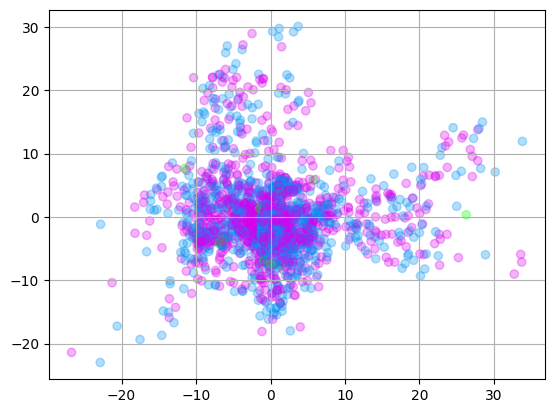

In [76]:
plt_embed = nlpsig.PlotEmbedding(x_data = x_data,
                                 y_data = dataset.df["label"].values)
plt_embed.plt_2d(
    embed_args = {
        "method": "pca",
        "dim": 2
    }
)

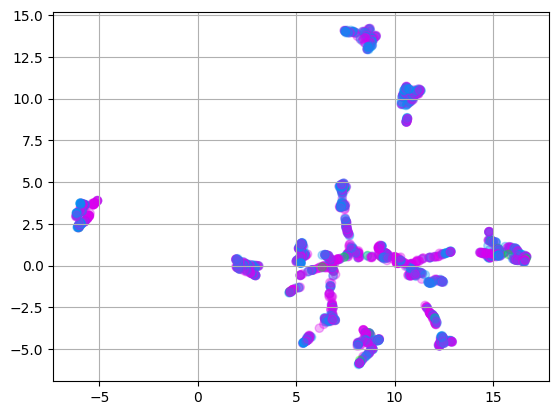

In [77]:
plt_embed.plt_2d(
    embed_args = {
        "method": "umap",
        "dim": 3
    }
)

## Training a FFN for classification

First we set some parameters for this specific example:

In [42]:
input_dim = x_data.shape[1]
hidden_dim = 200 #200
output_dim = 3
dropout_rate = 0.35 #0.35 #higher dropout than 0.25 and specifically 0.35 is very promising
num_epochs = 100
learning_rate = 0.0003 #0.0003 #empirically optimal lr value: 0.0001
gamma = 2 #3 #empirically optimal gamma value: 3
BATCH_SIZE = 64
NUM_folds = 5
patience = 2
weight_decay_adam = 0.0001

### KFold (splitting by groups)

The `GroupFolds` class in `nlpsig` splits the data in folds which can be used later on for K-Fold validation. We can pass in the groups into the initialisation of the object as follows:

In [43]:
data_folds = nlpsig.GroupFolds(df = dataset.df,
                               x_data = x_data,
                               y_data = torch.tensor(dataset.df["label"]),
                               groups = dataset.df["timeline_id"],
                               n_splits = NUM_folds)

By default, the class uses the [`GroupKFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html) class from [scikit-learn](https://scikit-learn.org/stable/). This ensures that each group will appear exactly once in the test set across all folds, but it does not allow for shuffling the dataset.

If you'd like to shuffle the dataset, you can set `shuffle = True` (remember to set a seed number in `random_state` - but even if you don't, this defaults to `42`). In this case, the class uses [`GroupShuffleSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html). This *does not* ensure that each group will appear at least once in a test set. So in this choice, it is possible that some groups are never used to test in the K-Fold evalatuion.

In [44]:
data_folds_shuffled = nlpsig.GroupFolds(df = dataset.df,
                                        x_data = x_data,
                                        y_data = torch.tensor(dataset.df["label"]),
                                        groups = dataset.df["timeline_id"],
                                        n_splits = NUM_folds,
                                        shuffle = True,
                                        random_state = 2022)

The indicies for each fold are saved in `fold_indices` attribute

In [45]:
data_folds.fold_indices[0]

(array([   0,    1,    2, ..., 1997, 1998, 1999]),
 array([ 488,  489,  490,  491,  492,  493,  494,  495,  496,  497,  498,
         499,  500,  501,  502,  503,  504,  505,  506,  507,  508,  509,
         510,  511,  512,  513,  514,  515,  516,  517,  518,  519,  520,
         521,  522,  523,  524,  525,  526,  527,  528,  529,  530,  531,
         532,  533,  534,  535,  536,  537,  538,  539,  540,  541,  542,
         543,  544,  545,  546,  547,  548,  549,  550,  551,  552,  553,
         554,  555,  556,  557,  558,  559,  560,  561,  562,  563,  564,
         565,  566,  567,  568,  569,  570,  571,  572,  573,  574,  575,
         576,  577,  578,  579,  580,  581,  582,  583,  584,  585,  586,
         587,  588,  589,  590,  591,  592,  593,  594,  595,  596,  597,
         598,  599,  600,  601,  602,  603,  604,  605,  606,  607,  608,
         609,  610,  611,  612,  613,  614,  615,  616,  617,  618,  619,
         620,  621,  622,  623,  624,  625,  626,  627,  628,

We can obtain training dataset, validation dataset, test datasets via the `.get_splits()` method, which slices the data using the indicies stored in `fold_indices` for a given fold. For example, if we wanted training, validation, and test datasets for the first fold, we have:

In [46]:
data_folds.get_splits(0)

(tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00, -8.6165e-01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00, -8.6165e-01],
         [ 0.0000e+00, -1.0716e+00,  2.6635e+00,  ..., -7.4506e-09,
           7.4506e-09, -8.6165e-01],
         ...,
         [ 0.0000e+00, -1.3126e+00,  2.0622e+00,  ..., -6.6639e+00,
          -2.8657e+00, -2.7305e-01],
         [ 0.0000e+00, -9.5420e-01,  4.5656e+00,  ..., -9.5276e+00,
           1.4164e+00, -2.7305e-01],
         [ 0.0000e+00, -3.0094e-01, -2.3632e-01,  ..., -2.7043e+00,
          -1.1181e+01, -2.7305e-01]]),
 tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
         0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 1, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2,
         2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0,
         2, 2, 2, 0, 0, 2, 0, 

By default, these will be in torch Tensors, but if we wanted them in as torch `DataLoader` objects, we set `as_DataLoader = True`:

In [47]:
data_folds.get_splits(fold_index = 0,
                      as_DataLoader = True)

(<torch.utils.data.dataloader.DataLoader at 0x2a1d53070>,
 <torch.utils.data.dataloader.DataLoader at 0x2a1d534f0>)

### Fitting a PyTorch model

There are `validation_pytorch`, `training_pytorch` and `testing_pytorch` functions which we can use to train our model. We will do this with the first fold given above:

In [48]:
train, valid, test = data_folds.get_splits(fold_index = 0,
                                           as_DataLoader = True)

`training_pytorch` does all the training (and uses the validation set and `validation_pytorch` to do so):

In [49]:
# initial model definitions
model = FeedforwardNeuralNetModel(input_dim,
                                  hidden_dim,
                                  output_dim,
                                  dropout_rate)
criterion = FocalLoss(gamma = gamma)
# set the alpha value in FocalLoss by passing in the y_labels
# I just noticed that you do this only using the y_labels for the training set, I'll fix this later!
criterion.set_alpha_from_y(y = torch.tensor(dataset.df["label"]))
optimizer = torch.optim.Adam(model.parameters(),
                             lr = learning_rate,
                             weight_decay = weight_decay_adam)

In [50]:
trained_model = nlpsig.training_pytorch(model = model,
                                        train_loader = train,
                                        valid_loader = valid,
                                        criterion = criterion,
                                        optimizer = optimizer,
                                        num_epochs=1000,
                                        seed = 2022,
                                        verbose = True)

Epoch: 1/1000 || Item: 0/1104 || Loss: 0.22246290743350983
Epoch: 1/1000 || Item: 1000/1104 || Loss: 0.600662112236023
--------------------------------------------------
##### Epoch: 1/1000 || Loss: 0.2657047510147095
--------------------------------------------------
Epoch: 1 || Loss: 0.5566740445227718 || Accuracy: 0.5477941036224365 || F1-score: 0.4258036733935069.
Early stopping at epoch 12!


Lets see how well it performs on the test set:

In [51]:
predicted, labels = nlpsig.testing_pytorch(model = model,
                                           test_loader = test)

In [52]:
print("accuracy: " + str(((predicted == labels).sum() / labels.size(0)).item()))

accuracy: 0.4630681872367859


### KFold evaluation of a PyTorch model

We have created a function called `KFold_pytorch` which allows you to pass in a `GroupFolds` object (which stores the folds and data), a Pytorch model, loss function and optimizer in and will perform the K-Fold evaluation. This returns the accuracy and F1-scores of each fold as a dataframe.

We need to initialise the models first. It is vital that these are untrained, as we will do the K-Fold evaluation by first saving the PyTorch model and optimizer states. For each fold, these are re-loaded and then training and testing is performed for that particular fold.

In [53]:
# initial model definitions
model = FeedforwardNeuralNetModel(input_dim,
                                  hidden_dim,
                                  output_dim,
                                  dropout_rate)
criterion = FocalLoss(gamma = gamma)
# set the alpha value in FocalLoss by passing in the y_labels
# I just noticed that you do this only using the y_labels for the training set, I'll fix this later!
criterion.set_alpha_from_y(y = torch.tensor(dataset.df["label"]))
optimizer = torch.optim.Adam(model.parameters(),
                             lr = learning_rate,
                             weight_decay = weight_decay_adam)

We simply pass this into `KFold_pytorch` function as follows:

In [54]:
kfold_eval = nlpsig.KFold_pytorch(data_folds,
                                  model = model,
                                  criterion = criterion,
                                  optimizer = optimizer,
                                  num_epochs = 1000,
                                  verbose_args = {
                                      "verbose": True,
                                      "verbose_epoch": 20,
                                      "verbose_item": 10000
                                  })


**************************************************
Fold: 1 / 5
**************************************************
Epoch: 1/1000 || Item: 0/1104 || Loss: 1.6029776334762573
--------------------------------------------------
##### Epoch: 1/1000 || Loss: 0.8922750353813171
--------------------------------------------------
Epoch: 1 || Loss: 0.4977462316301706 || Accuracy: 0.5238970518112183 || F1-score: 0.3506400409626216.
Early stopping at epoch 9!

**************************************************
Fold: 2 / 5
**************************************************
Epoch: 1/1000 || Item: 0/1111 || Loss: 1.5786627531051636
--------------------------------------------------
##### Epoch: 1/1000 || Loss: 0.524823784828186
--------------------------------------------------
Epoch: 1 || Loss: 0.5248538739707348 || Accuracy: 0.5364963412284851 || F1-score: 0.3045078708856734.
Early stopping at epoch 5!

**************************************************
Fold: 3 / 5
*********************************

The accuracy and F1-scores are then saved as follows:

In [55]:
kfold_eval

,accuracy,f1_score
0,0.542614,0.243677
1,0.416422,0.283423
2,0.473795,0.339904
3,0.491228,0.360212
4,0.522541,0.345063
